# PRODUCT PROPENSITY - PROD - Redshift - ALL NHL Data
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* July 14, 2022

## Hypothesis
This notebook will test the Product Propensity model features and the goal is to check how the accuracy and scores look when we train the model only with Canucks data compared to all NHL data.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [76]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from shared_utilities import helpers
from pycaret.classification import *

In [77]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

MJXB-FKLT
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [78]:
teams = [{'lkupclientid': 7, 'clientcode': 'canucks', 'stlrDBName': 'stlrcanucks'},
         {'lkupclientid': 33, 'clientcode': 'vgk', 'stlrDBName': 'stlrvgk'},
         {'lkupclientid': 36, 'clientcode': 'flames', 'stlrDBName': 'stlrflames'},
         {'lkupclientid': 55, 'clientcode': 'coyotes', 'stlrDBName': 'stlrcoyotes'},
         {'lkupclientid': 93, 'clientcode': 'nhlpanthers', 'stlrDBName': 'stlrnhlpanthers'}]

all_data = []
for team in teams:
    conn = helpers.get_redshift_connection('prod-app', team['stlrDBName'])
    
    # call the stored proc to get data for the product propensity model
    cur = conn.cursor()
    cur.execute(f"CALL {team['stlrDBName']}.ds.getproductpropensitymodeldata({team['lkupclientid']},2010, 2022, 'temp_cursor')")

    # create a named cursor based on the cursor name passed in above
    named_cursor = conn.cursor('temp_cursor')
    data = named_cursor.fetchall()

    # load the data and columns into a data frame
    cols = [row[0] for row in named_cursor.description]
    df = pd.DataFrame(data=data, columns=cols)
    all_data.append(df)
    
    conn.commit()

    

In [79]:
dfObj = pd.DataFrame(columns=['lkupclientid',
    'clientcode',
    'dimcustomermasterid', 
    'distance',
    'seasonyear',
    'events_prior',
    'attended_prior',
    'events_last',
    'attended_last',
    'tenure',
    'atp_last',
    'product_current',
    'product_last'])

In [80]:
for data in all_data:
    dfObj= dfObj.append(data)
dfObj.head()

,lkupclientid,clientcode,dimcustomermasterid,distance,seasonyear,events_prior,attended_prior,events_last,attended_last,tenure,atp_last,product_current,product_last
0,7,CANUCKS,3,748.34,2018,1,1,1,1,0,119.75,None,Individual
1,7,CANUCKS,3,748.34,2019,1,1,0,0,1,0.0,None,None
2,7,CANUCKS,3,748.34,2021,1,1,0,0,3,0.0,None,None
3,7,CANUCKS,3,748.34,2022,1,1,0,0,4,0.0,None,None
4,7,CANUCKS,4,2.96,2022,1,1,1,1,0,115.34,None,None


In [81]:
dfObj['clientcode'].unique()

array(['CANUCKS', 'VGK', 'FLAMES', 'COYOTES', 'NHLPANTHERS'], dtype=object)

In [55]:
# choose the features for the stellar base retention model
features = [
    "lkupclientid",
    "clientcode",
    "dimcustomermasterid", 
    "distance",
    "seasonyear",
    "events_prior",
    "attended_prior",
    "events_last",
    "attended_last",
    "tenure",
    "atp_last",
    "product_current",
    "product_last"
]

# copy your main dataframe
df_dataset = dfObj

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["seasonyear"] = pd.to_numeric(df_dataset["seasonyear"])
df_dataset = df_dataset.loc[df_dataset["seasonyear"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (2205781, 13)
Unseen Data For Predictions: (46092, 13)



In [56]:
setup(
    data= df_train, 
    target="product_current", 
    train_size = 0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=[
        "lkupclientid",
        "clientcode",
        "dimcustomermasterid",
        "seasonyear"
    ],
    numeric_features=[
        "distance",
    "events_prior",
    "attended_prior",
    "events_last",
    "attended_last",
    "tenure",
    "atp_last"
    ]
);

In [57]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9294,0.7959,0.2511,0.9023,0.9131,0.4085,0.4327,58.1930


In [58]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9268,0.7717,0.2723,0.9007,0.9122,0.4060,0.4189
1,0.9347,0.8003,0.2696,0.9041,0.9163,0.4312,0.4595
2,0.9355,0.8137,0.2760,0.9035,0.9168,0.4365,0.4660
3,0.9319,0.8057,0.2300,0.9035,0.9142,0.4119,0.4368
4,0.9303,0.7896,0.2160,0.9003,0.9126,0.3966,0.4214
5,0.9341,0.7968,0.2320,0.9000,0.9148,0.4158,0.4475
6,0.8972,0.7844,0.2694,0.9035,0.8968,0.3098,0.3124
7,0.9347,0.7948,0.2610,0.9008,0.9150,0.4208,0.4529
8,0.9358,0.8009,0.2489,0.9044,0.9168,0.4355,0.4663
9,0.9328,0.8008,0.2356,0.9018,0.9152,0.4212,0.4455


In [67]:
df_inference_year = dfObj.loc[dfObj["seasonyear"] >= 2022]
df_inference = df_inference_year.loc[df_inference_year["clientcode"] == 'CANUCKS']
df_inference = df_inference.fillna(0)
df_inference.shape

(390563, 13)

In [68]:
df_inference["clientcode"].unique()

array(['CANUCKS'], dtype=object)

In [69]:
df_inference["seasonyear"].unique()

array([2022])

In [70]:
new_predictions = predict_model(final_model, data=df_inference)
new_predictions.head()

,lkupclientid,clientcode,dimcustomermasterid,distance,seasonyear,events_prior,attended_prior,events_last,attended_last,tenure,atp_last,product_current,product_last,Label,Score
3,7,CANUCKS,3,748.34,2022,1,1,0,0,4,0.00,None,None,None,0.9872
4,7,CANUCKS,4,2.96,2022,1,1,1,1,0,115.34,None,None,None,0.9472
6,7,CANUCKS,6,251.61,2022,1,0,0,0,2,0.00,None,None,None,0.9917
11,7,CANUCKS,7,5.63,2022,1,1,0,0,5,0.00,None,None,None,0.9760
13,7,CANUCKS,8,251.61,2022,3,3,0,0,2,0.00,None,None,None,0.9611


In [71]:
new_predictions["Label"].value_counts()

None                 384700
Full Season            2861
Quarter                 781
Half Season             450
Groups                  383
Individual              357
Partial                 240
Premier/Core Plan       220
Partial Season          147
Mini Plan               132
Flex Plan                86
Group                    79
Mini-Plan                66
Mini Pack                61
Name: Label, dtype: int64

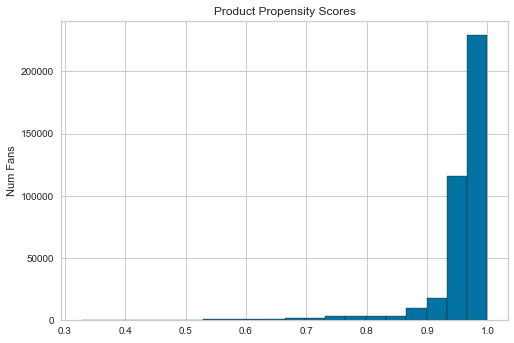

In [72]:
plt.hist(new_predictions["Score"], bins=20, edgecolor='black')
plt.title("Product Propensity Scores")
plt.ylabel("Num Fans")
plt.show()

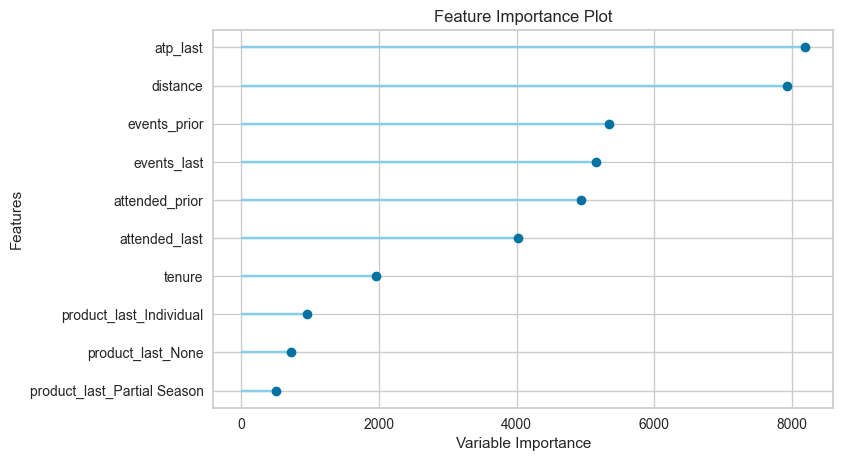

In [73]:
plot_model(final_model, plot='feature')

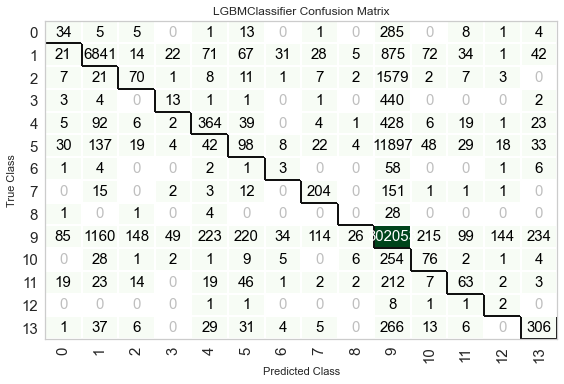

In [74]:
plot_model(final_model, plot='confusion_matrix')

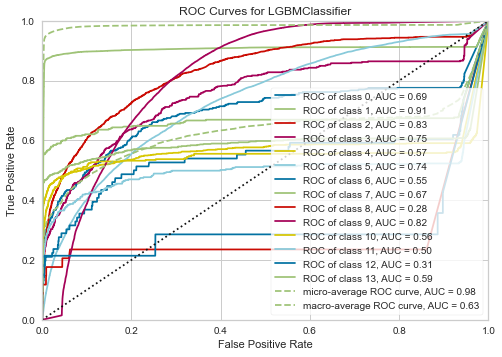

In [75]:
plot_model(final_model, plot='auc')

### Done